# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment

import numpy as np
import pandas as pd
import random
from collections import deque
import torch

import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Train the Agent

In [5]:
def ddpg_train(agent1,agent2):
    
    scores1 = []
    scores2 = []
    episode_max_scores = []
    global_max_score = -np.Inf
    solved = False

    n_episodes = 2000

    for episode in range(0, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]            # reset the environment
        state = env_info.vector_observations
        agent1.reset()                                                # reset the agent noise
        agent2.reset()
        score1 = 0
        score2 = 0
        
        while True:
            
            state1 = np.concatenate([state[0], [1]]).reshape((1,state.shape[1]+1))
            state2 = np.concatenate([state[1], [-1]]).reshape((1,state.shape[1]+1))
            
            action1 = agent1.act(state1)
            action2 = agent2.act(state2)
            
            env_info = env.step([action1, action2])[brain_name]      # send the action to the environment                            
            next_state = env_info.vector_observations                # get the next state        
            reward = env_info.rewards                                # get the reward        
            done = env_info.local_done                               # see if episode has finished        

            next_state1 = np.concatenate([next_state[0], [1]])
            next_state2 = np.concatenate([next_state[1], [-1]])
            
            agent1.step(state1, action1, np.mean(reward), next_state1, done[0]) # update the score
            agent2.step(state2, action2, np.mean(reward), next_state2, done[1])
            
            state = next_state                                     # roll over the state to next time step  

            score1 += reward[0]
            score2 += reward[1]
                  
            if np.any(done):                                      # exit loop if episode finished        
                break                                        

        scores1.append(score1)
        scores2.append(score2)
        episode_max_scores.append(np.max([score1, score2]))
        
        #mean1 = np.mean(scores1[-100:])
        #mean2 = np.mean(scores2[-100:])
        mean_score = np.mean(episode_max_scores[-100:])
        
        if episode % 100 ==0:
            print('Episode {}\tAverage score over last 100 episodes: {:.4f} \tMax score so far: {:.4f}'.format(
            episode, mean_score, global_max_score))
            torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor_1_episode{}.pth'.format(episode))
            torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic_1_episode{}.pth'.format(episode))
            torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor_2_episode{}.pth'.format(episode))
            torch.save(agent2.critic_local.state_dict(), 'checkpoint_critic_2_episode{}.pth'.format(episode))
        
        if np.max([score1, score2]) >= global_max_score:
            global_max_score = np.max([score1, score2])
            torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor_1_max.pth')
            torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic_1_max.pth')
            torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor_2_max.pth')
            torch.save(agent2.critic_local.state_dict(), 'checkpoint_critic_2_max.pth')
            
        if (mean_score >= 0.5) & (solved==False):
            print('\nEnvironment solved in {:d} episodes!\t\tAverage Score: {:.4f}\n'.format(episode-100, mean_score))
            solved = True

    return episode_max_scores, global_max_score

In [6]:
from maddpg_agent import Agent

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

RANDOM_SEED=2020
BUFFER_SIZE=int(1e5)  # replay buffer size
BATCH_SIZE=128        # minibatch size
GAMMA=0.99            # discount factor
TAU=1e-2              # for soft update of target parameters
FC1_UNITS_ACTOR=128   # output dim of first FC layer of actor
FC2_UNITS_ACTOR=64   # output dim of second FC layer of actor
FCS1_UNITS_CRITIC=128 # output dim of first FC layer of critic
FC2_UNITS_CRITIC=64  # output dim of second FC layer of critic
LR_ACTOR=1e-3         # learning rate of the actor 
LR_CRITIC=1e-3        # learning rate of the critic
WEIGHT_DECAY=0        # L2 weight decay


agent1 = Agent(device, num_agents, state_size+1, action_size, random_seed=RANDOM_SEED, buffer_size=BUFFER_SIZE,
               batch_size=BATCH_SIZE, gamma=GAMMA, tau=TAU, fc1_units_actor=FC1_UNITS_ACTOR, fc2_units_actor=FC2_UNITS_ACTOR,
               fcs1_units_critic=FCS1_UNITS_CRITIC, fc2_units_critic=FC2_UNITS_CRITIC, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC,
               weight_decay=WEIGHT_DECAY, update_local=1, n_updates=1)       

agent2 = Agent(device, num_agents, state_size+1, action_size, random_seed=RANDOM_SEED, buffer_size=BUFFER_SIZE,
               batch_size=BATCH_SIZE, gamma=GAMMA, tau=TAU, fc1_units_actor=FC1_UNITS_ACTOR, fc2_units_actor=FC2_UNITS_ACTOR,
               fcs1_units_critic=FCS1_UNITS_CRITIC, fc2_units_critic=FC2_UNITS_CRITIC, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC,
               weight_decay=WEIGHT_DECAY, update_local=1, n_updates=1)    

# Update agent2 param to be same as agent1
agent2.actor_local = agent1.actor_local
agent2.actor_target = agent1.actor_target
agent2.actor_optimizer = agent1.actor_optimizer

agent2.critic_local = agent1.critic_local
agent2.critic_target = agent1.critic_target
agent2.critic_optimizer = agent1.critic_optimizer

agent2.memory = agent1.memory

# train the agent
episode_scores, max_score = ddpg_train(agent1, agent2)

Episode 0	Average score over last 100 episodes: 0.0000 	Max score so far: -inf
Episode 100	Average score over last 100 episodes: 0.0134 	Max score so far: 0.1900
Episode 200	Average score over last 100 episodes: 0.0331 	Max score so far: 0.2000
Episode 300	Average score over last 100 episodes: 0.0440 	Max score so far: 0.2000
Episode 400	Average score over last 100 episodes: 0.0669 	Max score so far: 0.3000
Episode 500	Average score over last 100 episodes: 0.1107 	Max score so far: 0.3000
Episode 600	Average score over last 100 episodes: 0.1751 	Max score so far: 1.4000
Episode 700	Average score over last 100 episodes: 0.3803 	Max score so far: 1.7000
Episode 800	Average score over last 100 episodes: 0.3512 	Max score so far: 2.3000
Episode 900	Average score over last 100 episodes: 0.4846 	Max score so far: 2.6000

Environment solved in 804 episodes!		Average Score: 0.5216

Episode 1000	Average score over last 100 episodes: 0.4851 	Max score so far: 2.6000
Episode 1100	Average score ov

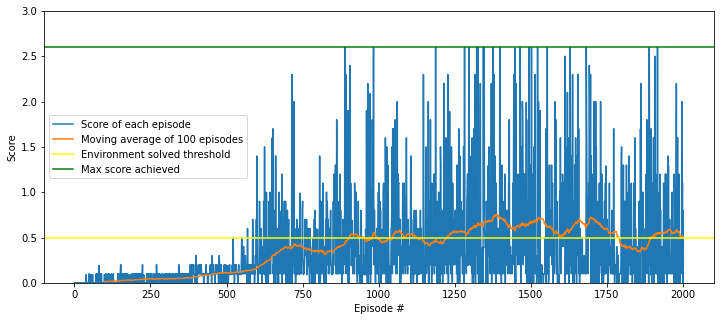

In [7]:
# plot scores
plt.figure(figsize=(12, 5))
plt.plot(np.arange(1, len(episode_scores)+1), episode_scores, label='Score of each episode')

plt.plot(np.arange(1, len(episode_scores)+1), pd.Series(episode_scores).rolling(window=100).mean(), label='Moving average of 100 episodes')

plt.axhline(y=0.5, color='yellow', linestyle='-', label='Environment solved threshold')
plt.axhline(y=max_score, color='green', linestyle='-', label='Max score achieved')
plt.legend()
plt.ylim([0.0, 3.0])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()    

### 4. Watch a Trained Agent

In [8]:
agent1.actor_local.load_state_dict(torch.load('checkpoint_actor_1_max.pth'))
agent1.critic_local.load_state_dict(torch.load('checkpoint_critic_1_max.pth'))
agent2.actor_local.load_state_dict(torch.load('checkpoint_actor_2_max.pth'))
agent2.critic_local.load_state_dict(torch.load('checkpoint_critic_2_max.pth'))


env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
state = env_info.vector_observations                  # get the current state (for each agent)

score1 = 0
score2 = 0

while True:
    state1 = np.concatenate([state[0], [1]]).reshape((1,state.shape[1]+1))
    state2 = np.concatenate([state[1], [-1]]).reshape((1,state.shape[1]+1))
            
    action1 = agent1.act(state1)
    action2 = agent2.act(state2)
    
    env_info = env.step([action1, action2])[brain_name]    # send all actions to tne environment
    next_state = env_info.vector_observations         # get next state (for each agent)
    reward = env_info.rewards                         # get reward (for each agent)
    done = env_info.local_done                        # see if episode finished
    
    next_state1 = np.concatenate([next_state[0], [1]])
    next_state2 = np.concatenate([next_state[1], [-1]])

    agent1.step(state1, action1, np.mean(reward), next_state1, done[0]) # update the score
    agent2.step(state2, action2, np.mean(reward), next_state2, done[1])
    
    state = next_state                                     # roll over the state to next time step  

    score1 += reward[0]
    score2 += reward[1]
    
    if np.any(done):                                  # exit loop if episode finished
        break
        
print('Total score (averaged over agents) this episode: {}'.format(np.mean([score1, score2])))

Total score (averaged over agents) this episode: 1.7950000269338489


When finished, you can close the environment.

In [9]:
env.close()